This is a training of the model on both categorical and numerical data. I find the best possible value of alpha by computing a 5-fold Cross Validation for every possible value of alpha in range(0,40000,1000) and selecting the one that is the closest to maximizing the R2 score and minimizing the RMSE score computed by each cycle of 5_fold CV

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from category_encoders import TargetEncoder
from sklearn.linear_model import Ridge

In [2]:
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns

In [3]:
class My_Ridge :
    def __init__(self,alpha) :
        self.alpha = alpha
        self.coefficients = None

    def fit(self, X, y):
        if "intercept" not in X:
            X.insert(0,"intercept",1, True)
    
        n_feat= X.shape[1]
        I=np.eye(n_feat)
        I[0][0]=0
    
        A = np.dot(X.T, X) + self.alpha * I
        b = np.dot(X.T, y)
        self.coefficients = np.dot(np.linalg.inv(A),b)

    def predict(self, X):
        if "intercept" not in X:
            X.insert(0,"intercept",1, True)
        return np.dot(X,self.coefficients)
    
    def r2score(self,Y_pred, Y_act):
        return r2_score(Y_act,Y_pred)
    
    def mse_score(self,Y_pred, Y_act):
        return mean_squared_error(Y_act,Y_pred,squared=False)

In [4]:
spotify = pd.read_csv("dataset.csv")

In [5]:
spotify=spotify.drop(columns = "Unnamed: 0")
spotify=spotify.drop(columns = "album_name")
spotify=spotify.drop(columns = "track_name")
spotify=spotify.drop(columns = "track_id")
cor = spotify.corr()

In [6]:
cor["popularity"]

popularity          1.000000
duration_ms        -0.007101
explicit            0.044082
danceability        0.035448
energy              0.001056
key                -0.003853
loudness            0.050423
mode               -0.013931
speechiness        -0.044927
acousticness       -0.025472
instrumentalness   -0.095139
liveness           -0.005387
valence            -0.040534
tempo               0.013205
time_signature      0.031073
Name: popularity, dtype: float64

In [7]:
cor_target= abs(cor["popularity"]) #maintain only the numerical values with correlation with popularity higher of 0.02
relevant_feat = cor_target[cor_target > 0.02]
relevant_feat

popularity          1.000000
explicit            0.044082
danceability        0.035448
loudness            0.050423
speechiness         0.044927
acousticness        0.025472
instrumentalness    0.095139
valence             0.040534
time_signature      0.031073
Name: popularity, dtype: float64

In [9]:
spotify=spotify.drop(columns = "acousticness")
spotify=spotify.drop(columns = "tempo")
spotify=spotify.drop(columns = "duration_ms")
spotify=spotify.drop(columns = "energy")
spotify=spotify.drop(columns = "key")
spotify=spotify.drop(columns = "mode")
spotify=spotify.drop(columns = "liveness")
spotify

,artists,popularity,explicit,danceability,loudness,speechiness,instrumentalness,valence,time_signature,track_genre
0,Gen Hoshino,73,False,0.676,-6.746,0.1430,0.000001,0.7150,4,acoustic
1,Ben Woodward,55,False,0.420,-17.235,0.0763,0.000006,0.2670,4,acoustic
2,Ingrid Michaelson;ZAYN,57,False,0.438,-9.734,0.0557,0.000000,0.1200,4,acoustic
3,Kina Grannis,71,False,0.266,-18.515,0.0363,0.000071,0.1430,3,acoustic
4,Chord Overstreet,82,False,0.618,-9.681,0.0526,0.000000,0.1670,4,acoustic
...,...,...,...,...,...,...,...,...,...,...
113995,Rainy Lullaby,21,False,0.172,-16.393,0.0422,0.928000,0.0339,5,world-music
113996,Rainy Lullaby,22,False,0.174,-18.318,0.0401,0.976000,0.0350,4,world-music
113997,Cesária Evora,22,False,0.629,-10.895,0.0420,0.000000,0.7430,4,world-music
113998,Michael W. Smith,41,False,0.587,-10.889,0.0297,0.000000,0.4130,4,world-music


In [10]:
encoder = TargetEncoder(smoothing=300)
cat_cols =['artists','explicit','track_genre']

In [11]:
k_Fold=KFold(n_splits=5,shuffle=True)

In [12]:
av=np.eye(40,1)
avr=np.eye(40,1)     

In [ ]:
i=0
for alphas in range(0,40000,1000): #I cycle on the alpha to find the one that gives us the best scores
    average_rscore=0.0
    average_msescore=0.0

    ridge = My_Ridge(alpha=alphas)
    for train_index, test_index in k_Fold.split(spotify): #cross validation code
        train,test = (spotify.T[train_index]).T, (spotify.T[test_index]).T
        
        train[cat_cols] = encoder.fit_transform(train[cat_cols], train["popularity"]) #encoding of the categorical features
        test[cat_cols] = encoder.transform(test[cat_cols])
        train=train.dropna(axis=0)
        test=test.dropna(axis=0)
    
        y = train["popularity"].copy()
        yt=(np.array([y])).T
        yt=yt.astype(np.int64)
    
        X = (train.drop(columns= 'popularity'))
        X_test=(test.drop(columns= 'popularity'))
    
        x_mean=X.mean() #normalizing training and testing data
        x_std=X.std()
        X = (X - x_mean) / x_std
        X_test=(X_test-x_mean)/x_std
        X=X.astype(np.float64)
        X_test=X_test.astype(np.float64)
        
        ridge.fit(X,yt)
        predictions=ridge.predict(X_test)
        
        expect= np.array(test["popularity"]) #actual training labels
        expect = np.reshape(expect,(-1,1))
    
        rscore=ridge.r2score(predictions,expect) #r2 score of the prediction
        msescore=ridge.mse_score(predictions,expect) #rmse score of the prediction
        average_rscore += rscore
        average_msescore += msescore
    av[i]=average_msescore/5 #computing the average of the r2 and rmse scores over the 5 folds
    avr[i]=average_rscore/5
    i=i+1
    print(alphas)
    print(av[i-1])
    print(avr[i-1])

[Text(0.5, 0, 'alpha/1000'), Text(0, 0.5, 'R2'), Text(0.5, 1.0, 'R2 vs alpha')]

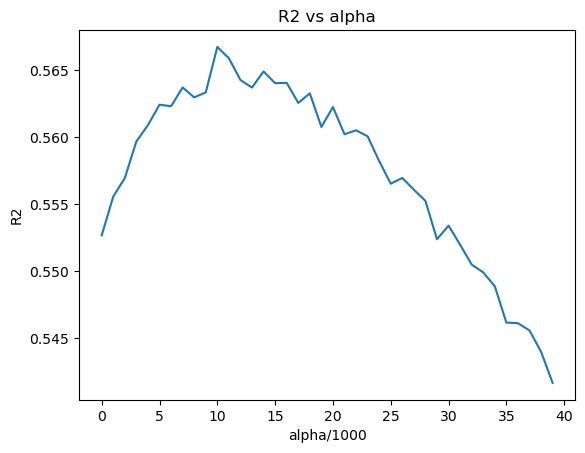

In [16]:
ax=plt.subplot()
ax.plot(avr)
ax.set(xlabel='alpha/1000', ylabel='R2',
       title='R2 vs alpha')

[Text(0.5, 0, 'alpha/1000'),
 Text(0, 0.5, 'RMSE'),
 Text(0.5, 1.0, 'RMSE vs alpha')]

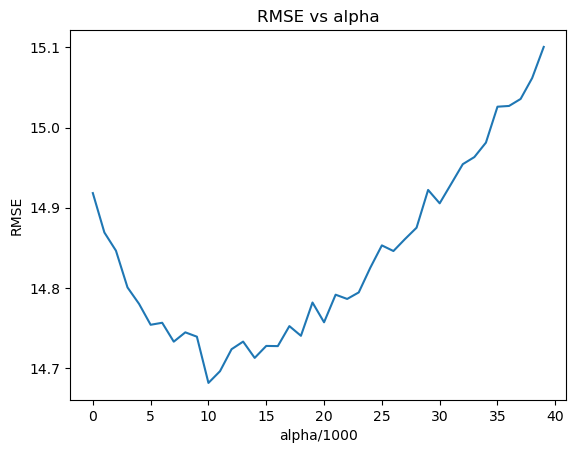

In [15]:
ax=plt.subplot()
ax.plot(av)
ax.set(xlabel='alpha/1000', ylabel='RMSE',
       title='RMSE vs alpha')

In [18]:
best_alpha= np.argmin(av)*1000
best_alpha

10000